# Tests for DARPA Report

In [1]:
import sys; sys.path.insert(0, '..')
import ast
import time
import numpy as np
import matplotlib.pyplot as plt
from fimdp.UUVEnv import Env
from IPython import display
from matplotlib.colors import ListedColormap
import seaborn as sns
from fimdp.energy_solver import *

### MDP Domain and Synthesis

The MDP models the dynamics of an unmanned underwater vehicle (UUV) moving with a constant horizontal velocity in oceans whose current velocity vector is known apriori. The region of interest is discretized into a 2-dimensional grid where each cell in the grid forms a state in the MDP. Movement in north, south, east, and west directions form the action space. The actions are of two kinds: strong and weak. Strong actions, while consuming more energy, lead to deterministic outcomes where as weak actions have stochastic outcomes while consuming less energy. We first generate an example MDP using the following syntax and convert it into a consMDP object. In this MDP, a single target state near one corner of the grid and the reload state (which is also the initial state of the agent) is near the other corner. 

In [39]:
# Input Variables

# Essential
grid_size = (40,40) # size of the grid
agent_capacity = 500 # maximum energy capacity of the agent
init_state = 5*grid_size[0]+2 # Initial state of the agent
reload_list = [10*grid_size[0]+4, 12*grid_size[0] - 5] # list of reload states in the MDP
target_list = [grid_size[0]*grid_size[1] - 3*grid_size[0] - 8] # list of target states in the MDP

# Non essential 
agent_velocity = 5 # horizontal velocity of the glider
heading_sd = 0.524 # standard deviation in agent true heading
weakaction_cost= 1 # cost of weak action of the agent
strongaction_cost = 2 # cost of strong action of the agent

# Generate MDP and export to consMDP
env = Env(grid_size, agent_velocity, heading_sd, agent_capacity, weakaction_cost, strongaction_cost, reload_list, target_list, init_state=init_state, render=False)
m, targets = env.create_consmdp()

# Strategy Synthesis and Implementation

We now generate the strategy using the 'EnergySolver' variant solver for almost-sure reachability objective for the given capacity and use the strategy to reach the target state. The following two functions help us in implementing the strategy and visualizing the results.


In [35]:
# Function to take action based on the strategy
def policy(strategy,state,energy):
    
    data_dict = strategy[state]
    dict_keys = list(data_dict.keys())
    
    if len(dict_keys) == 0:
        raise Exception('Strategy does not prescribe a safe action at this state. Increase the capacity of the agent.')
    feasible = []
    for value in dict_keys:
        if value <= energy:
            feasible.append(value)
    
    action_string = data_dict[max(feasible)]
    agent_action = ast.literal_eval(action_string)[1]
    
    return agent_action

In [32]:
# Function to render the grid world
def rendering(env, time_count):

    data = -3*np.ones([env.grid_size[0],env.grid_size[1]])
    for cell in env.states_history:
        data[cell//env.grid_size[0], cell%env.grid_size[1]] = 3
        data[env.position//env.grid_size[0], env.position%env.grid_size[1]] = -1
    for cell in env.target_list:
        data[cell//env.grid_size[0], cell%env.grid_size[1]] = 1
    for cell in env.reload_list:
        data[cell//env.grid_size[0], cell%env.grid_size[1]] = 0            

    myColors = ['#A9A9A9',(0.7, 0.0, 0.0, 1.0),(0.7, 0.3, 0.0, 1.0), (0.0, 0.8, 0.0, 1.0),'#5C5959']
    cmap = ListedColormap(myColors)
    plt.clf()
    ax = sns.heatmap(data, cmap=cmap, cbar =False, linewidths=.5, linecolor='lightgray')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_title("Agent motion: t = {}".format(time_count))
    plt.pause(0.01)

Target reached.


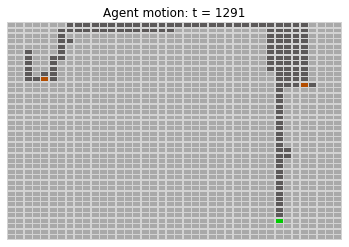

In [40]:
# Generate strategy
s = EnergySolver(m, cap=agent_capacity, targets=targets)
strategy = s.get_strategy(AS_REACH, recompute=True)

# Run simulation using the strategy
time_count = 0
env.reset(init_state)

while True:
       
    energy = env.agent_energy
    state = env.position
     # info = (next_state, action taken, reward, done)
    info = env.step(policy(strategy,state,energy)) # take action
    time_count += 1

    if info[0] in target_list:
        print("Target reached.")
        rendering(env, time_count)
        break
    elif info[3] == 1:
        print("Energy exhausted.")
        rendering(env, time_count)
        break

Note that in the above figure, green cell indicates the target state and orange cells indicate the reload states. Further, the orange cell closer to the top right corner is also the initial state of the agent. The trajectory of the agent is indicated by dark grey cells. The no.of time steps taken to reach the target is indicated in the title of the figure.

# Variation of time to reach target with agent capacity

We now run the above configuration for different values of agent capacities to see how long the agent takes, on average, to reach the target state. Intuitively, an agent with higher capacity will feel more confident about reaching the target state directly while ensuring safety when compared to agent with lower capacity that would try to stay close to some reload state and hence loiters around. However, the average time-to-target results from the simulation below does not follow this trend, likely due to the small no.of samples considered to calculate the mean value.

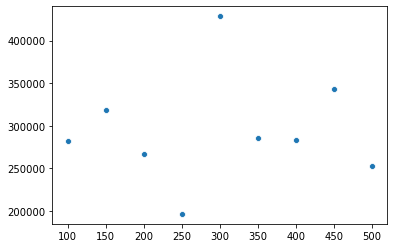

In [62]:
# Function that calculates average time to reach target for different capacities and plots the data

capacities_list = np.arange(100,550,50)
attempts_count = 10
timing_list = []

for capacity in capacities_list:
    
    # gen strategy
    s = EnergySolver(m, cap=capacity, targets=targets)
    strategy = s.get_strategy(AS_REACH, recompute=True)
    time_diffattempts = []
    for count in range(attempts_count):   
        # run simulation
        time_count = 0
        env.reset(init_state)
        while True:
            energy = env.agent_energy
            state = env.position
            try:
                info = env.step(policy(strategy,state,energy)) # take action
                time_count += 1
            except:
                break
            if info[0] in target_list:
                time_diffattempts.append(time_count)
                break

    timing_list.append(np.mean(time_diffattempts))
        
# Plot timing data
sns.scatterplot(capacities_list, timing_list)